# Inverted pendulum

In [1]:
import numpy as np
import torch as tch
from torch import nn

In [2]:
dev = tch.device("cuda:0")

In [3]:
def make_step(state: tch.Tensor, action: tch.tensor, dt: float) -> tch.Tensor:
    """
    Inverted pendulum simulation step
    `state` - tensor of shape (batch_size, 2) where last dim items are [angle, angular_velocity]
    `action` - tensor of shape (batch_size, 1) containing torque direction
    """
    moment_of_inertia = 1.0
    gravity = 9.8
    friction = 6e-1
    max_torque = 4.0

    angle, angular_velocity = state[:, 0], state[:, 1]
    torque = max_torque * action[:, 0]
    acceleration = (torque - friction * angular_velocity) / moment_of_inertia - gravity * angle.cos()
    # TODO: Use RK4 instead of Euler method
    return tch.stack([angle + angular_velocity * dt, angular_velocity + acceleration * dt], dim=1).detach()

In [29]:
def get_score(state: tch.Tensor) -> tch.Tensor:
    angle, angular_velocity = state[:, 0], state[:, 1]
    return angle.sin() # - angular_velocity.abs()

In [5]:
from time import sleep
import matplotlib.pyplot as plt
from ipycanvas import Canvas, hold_canvas
from IPython.display import display, clear_output

In [6]:
def draw_state(state: np.ndarray, canvas: Canvas):
    from math import sin, cos, sqrt

    moment_of_inertia = 1.0
    angle, angular_velocity = state

    with hold_canvas():
        canvas.clear()
        canvas.fill_style = "yellow"
        canvas.stroke_style = "black"

        length = 0.75 * min(canvas.width, canvas.height) / 2
        center = np.array([canvas.width / 2, canvas.height / 2])
        position = center + np.array([length * cos(angle), -length * sin(angle)])
        canvas.stroke_line(*center, *position)
        size = 0.1 * length * sqrt(moment_of_inertia)
        canvas.fill_circle(*position, size)
        canvas.stroke_circle(*position, size)

In [7]:
canvas = Canvas(width=640, height=640)
display(canvas)

Canvas(height=640, width=640)

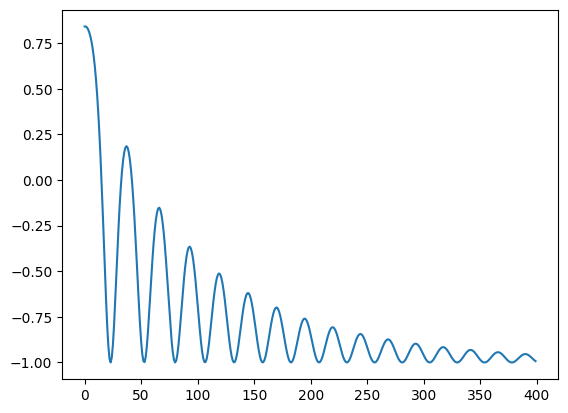

In [8]:
dt = 1 / 24
plot_period = 100

state = tch.tensor([[1.0, 0.0]])
score = []

for i in range(400):
    draw_state(state.squeeze(0).numpy(force=True), canvas)

    score.append(get_score(state).squeeze().numpy(force=True))
    if (i + 1) % plot_period == 0:
        clear_output()
        plt.plot(score)
        plt.show()
    
    state = make_step(state, tch.zeros((1, 1)), dt)
    sleep(dt)

## Policy gradients

In [44]:
def make_input(state: tch.Tensor) -> tch.Tensor:
    angle, angular_velocity = state[:, 0], state[:, 1]
    return tch.stack([angle.sin(), angle.cos(), angular_velocity.tanh()], dim=1)

In [45]:
dim = 64
model = nn.Sequential(
    nn.Linear(3, dim),
    nn.ReLU(),
    nn.Linear(dim, 1),
    nn.Tanh(),
)
model = model.to(dev)

In [46]:
batch_size = 1024
optim = tch.optim.AdamW(model.parameters(), lr=1e-3)

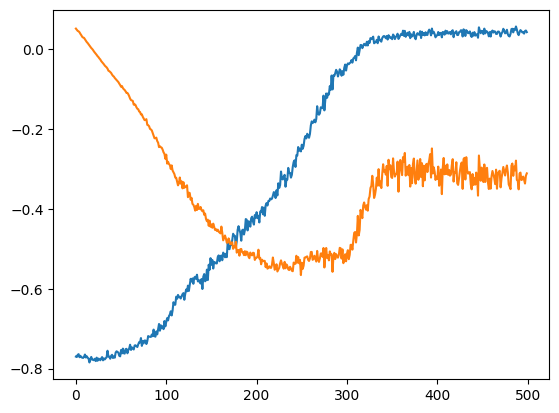

In [47]:
num_iters = 200
dt = 1 / 24

score_log = []
loss_log = []

for epoch in range(500):
    model.zero_grad()

    state = tch.stack([2 * np.pi * tch.rand(batch_size), tch.randn(batch_size)], dim=1).to(dev)
    score_sum = tch.zeros(batch_size).to(dev)
    action_sum = tch.zeros(batch_size).to(dev)

    for i in range(num_iters):
        input = make_input(state)
        action: tch.Tensor = model.forward(input)
        score = get_score(state)
        state = make_step(state, action, dt).detach()
        
        score_sum += score
        action_sum += action.squeeze(1)

    score_sum /= num_iters
    action_sum /= num_iters
    mean_score = score_sum.mean()
    score_sum -= mean_score
    score_sum /= score_sum.var().sqrt()
    loss = -(score_sum * action_sum).mean()
    loss.backward()
    optim.step()

    score_log.append(mean_score.numpy(force=True))
    loss_log.append(loss.numpy(force=True))
    clear_output()
    plt.plot(score_log)
    plt.plot(loss_log)
    plt.show()

In [48]:
canvas = Canvas(width=640, height=640)
display(canvas)

Canvas(height=640, width=640)

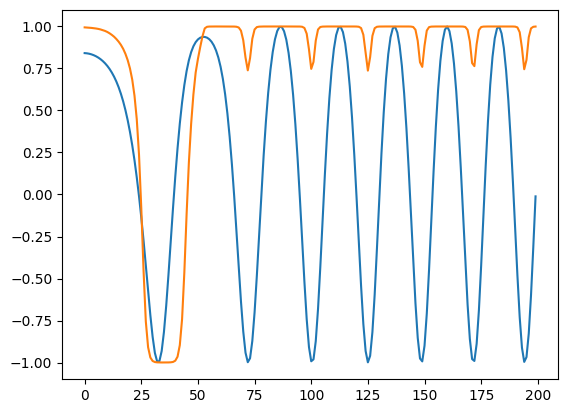

In [49]:
dt = 1 / 24
plot_period = 100

state = tch.tensor([[1.0, 0.0]]).to(dev)
scores = []
actions = []

for i in range(num_iters):
    draw_state(state.squeeze(0).numpy(force=True), canvas)

    input = make_input(state)
    action: tch.Tensor = model.forward(input)
    state = make_step(state, action, dt).detach()

    scores.append(get_score(state).squeeze().numpy(force=True))
    actions.append(action.squeeze().numpy(force=True))
    if (i + 1) % plot_period == 0:
        clear_output()
        plt.plot(scores)
        plt.plot(actions)
        plt.show()
    
    sleep(dt)